Endprojekt GIS Analyse - Location Analysis for a new Stadium in Graz

In [24]:
# Data manipulation
import pandas as pd
import numpy as np

# Geospatial
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon
import osmnx as ox
import pyproj

# Raster processing
import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS

# Misc / plotting
import os
import matplotlib.pyplot as plt


In [3]:
'''Data Preparation'''
#loading GeoJson Districts of Graz
gdf_districts = gpd.read_file("data/district_graz.geojson")
gdf_districts = gdf_districts[["name", "geometry"]].copy() #extract the columns needed

#loading csv with pop data of graz 
df_popgraz = pd.read_csv("data/Bevoelkerung Graz.csv", encoding="latin1", sep=";")

#merge the two datasets
gdf_districts_popGraz = gdf_districts.merge(df_popgraz, left_on="name", right_on="Bezirk")

In [4]:
PLACE_NAME:str = "Graz, Austria"

In [5]:
#Exclusion Water Bodies
tags_water = {
    "natural": ["water"],
    "waterway": ["river", "stream", "canal", "ditch"],
    "landuse": ["reservoir"],
    "water": ["lake", "river", "pond", "basin"]
}
gdf_water = ox.features_from_place(
    PLACE_NAME,
    tags=tags_water
)
gdf_water = gdf_water[["geometry"]].copy()
gdf_water["category"] = "water"

In [6]:
#Excklusion Parks
tags_parks = {
    "leisure": [
        "park", "garden", "playground", "recreation_ground"
    ],
    "boundary": [
        "protected_area"
    ]
}
gdf_parks = ox.features_from_place(
    PLACE_NAME,
    tags=tags_parks
)

gdf_parks = gdf_parks[["geometry"]].copy()
gdf_parks["category"] = "green areas"

In [7]:
#Exclusion Transport Areas
tags_transport = {
    "highway": [
        "motorway", "trunk", "primary", "secondary", "tertiary",
        "motorway_link", "trunk_link", "primary_link", "secondary_link"
    ],
    "railway": [
        "rail", "tram", "light_rail", "subway"
    ]
}

gdf_transport = ox.features_from_place(
    PLACE_NAME,
    tags=tags_transport
)

gdf_transport = gdf_transport[["geometry"]].copy()
gdf_transport["category"] = "transport infrastructure"


In [ ]:
#Exclusion Buildings
tags_buildings_hard = {
    "building": True
}

gdf_buildings = ox.features_from_place(
    PLACE_NAME,
    tags=tags_buildings_hard
)

gdf_buildings = gdf_buildings[["geometry"]].copy()
gdf_buildings["category"] = "buildings_hard"

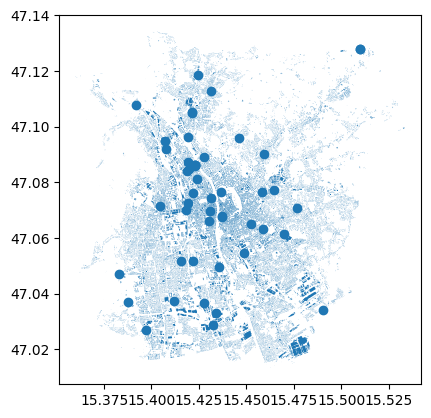

In [18]:
gdf_buildings.plot()
plt.show()
#Points are yet to remove

In [ ]:
'''Chathilfe: noch umändern!'''
#+Projection of DEM is changed from WGS84 to UTM33N

# --- Workaround: proj-Datenbank setzen ---
os.environ["PROJ_LIB"] = pyproj.datadir.get_data_dir()

dem_in = "data/DEM30_Graz.tif"          # Original DEM
dem_utm = "data/DEM30_Graz_utm33.tif"   # Output DEM (UTM33N)

with rasterio.open(dem_in) as src:

    # --- Sicherstellen, dass das CRS gesetzt ist ---
    src_crs = src.crs if src.crs is not None else CRS.from_epsg(4326)
    dst_crs = CRS.from_epsg(32633)  # UTM Zone 33N

    # --- Transform, neue Dimensionen berechnen ---
    transform, width, height = calculate_default_transform(
        src_crs, dst_crs, src.width, src.height, *src.bounds
    )

    # --- Profil kopieren und anpassen ---
    profile = src.profile.copy()
    profile.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "nodata": src.nodata if src.nodata is not None else -9999
    })

    # --- Reprojektieren ---
    with rasterio.open(dem_utm, "w", **profile) as dst:
        # Zielband initialisieren (NoData)
        dst_array = np.full((height, width), profile["nodata"], dtype=profile["dtype"])
        dst.write(dst_array, 1)

        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src_crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
            src_nodata=src.nodata,
            dst_nodata=profile["nodata"]
        )

print("Wrote:", dem_utm)
''''''

Wrote: data/DEM30_Graz_utm33.tif


In [40]:
import numpy as np
import rasterio

dem_utm = "data/DEM30_Graz_utm33.tif"
slope_out_pct = "data/DEM30_Graz_slope_pct.tif"

with rasterio.open(dem_utm) as src:
    dem = src.read(1).astype("float32")
    nodata = src.nodata

    xres = abs(src.transform.a)
    yres = abs(src.transform.e)

    # NoData -> NaN für Berechnung
    if nodata is not None:
        dem[dem == nodata] = np.nan

    # Gradient dz/dx, dz/dy
    dy, dx = np.gradient(dem, yres, xres)

    # Slope in Grad
    slope_deg = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))

    # Grad -> Prozent
    slope_pct = np.tan(np.deg2rad(slope_deg)) * 100

    # NaN wieder als nodata
    slope_pct = np.where(np.isnan(slope_pct), -9999, slope_pct).astype("float32")

    # Rasterprofil kopieren & anpassen
    profile = src.profile.copy()
    profile.update(dtype="float32", nodata=-9999)

    # Ergebnis schreiben
    with rasterio.open(slope_out_pct, "w", **profile) as dst:
        dst.write(slope_pct, 1)  # <-- hier muss das Array stehen, nicht der Dateiname

print("Wrote:", slope_out_pct)


Wrote: data/DEM30_Graz_slope_pct.tif


In [41]:
#Check Projection and Pixel Size
with rasterio.open("data/DEM30_Graz_utm33.tif") as src:
    print(src.crs)
    print("Pixel size (m):", abs(src.transform.a), abs(src.transform.e))

EPSG:32633
Pixel size (m): 23.68908883499651 23.68908883499651


CRS: EPSG:32633
Pixel size (m): 23.68908883499651 23.68908883499651


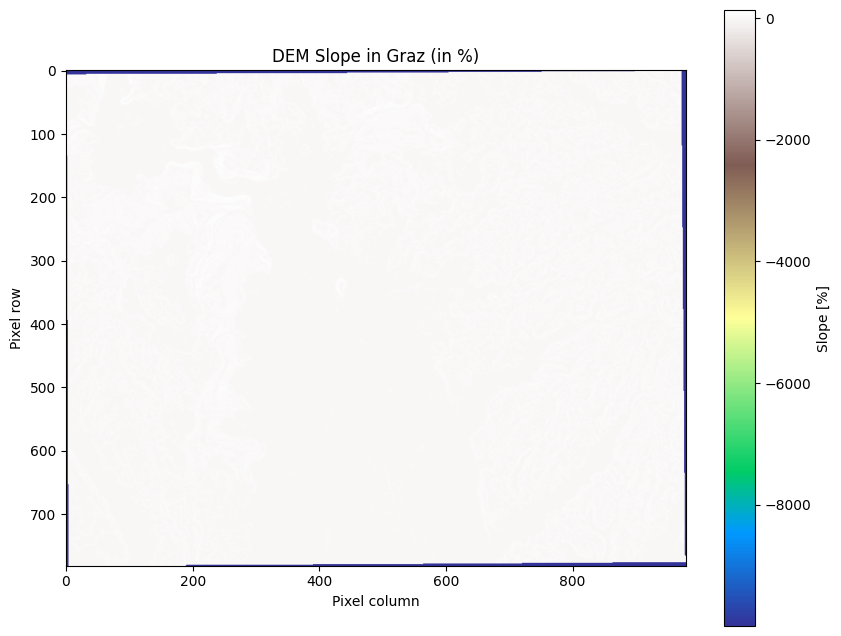

In [42]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Raster öffnen
with rasterio.open("data/DEM30_Graz_slope_pct.tif") as src:
    slope_deg = src.read(1)  # Band 1
    crs = src.crs
    transform = src.transform
    print("CRS:", crs)
    print("Pixel size (m):", abs(transform.a), abs(transform.e))

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(slope_pct, cmap="terrain", origin="upper")
plt.colorbar(label="Slope [%]")  # jetzt Prozent
plt.title("DEM Slope in Graz (in %)")
plt.xlabel("Pixel column")
plt.ylabel("Pixel row")
plt.show()
